# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier With Transfer Learning

## Step 0: Load The Data

Use this link to download the data used for this project [Link to Data](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

In [4]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
    pass
# Load pickled data
import pickle
import numpy as np
import cv2
import csv
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import tensorflow_hub as hub


training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [6]:
test_set = test_set.map(lambda image, label: (tf.image.resize(image, (160, 160)), label))
validation_set = validation_set.map(lambda image, label: (tf.image.resize(image, (160, 160)), label))
train_dataset = train_dataset.map(lambda image, label: (tf.image.resize(image, (160, 160)), label))

In [7]:
print(validation_set)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.uint8)>


---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

### Include an exploratory visualization of the dataset

In [8]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape =  (X_test.shape[1],  X_test.shape[1])
n_classes = max(test['labels']) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [10]:
class_names = []
with open('signnames.csv','rt')as f:
    data = csv.reader(f)
    for row in data:
        sign_name = list(row)[1]
        if(sign_name != 'SignName'):
            class_names.append(sign_name)

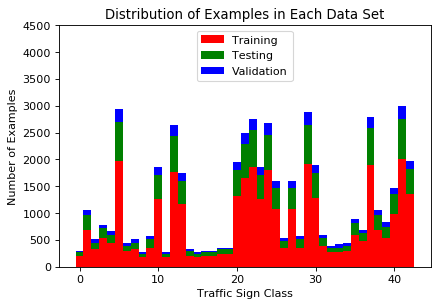

In [11]:
def print_distribution(y_train, y_test, y_valid):
    distribution = {}
    sign_class = []
    sign_num = [[],[],[]]
    
    for image in y_train:
        if(distribution.get(class_names[image]) != None):
            distribution[class_names[image]][0] = distribution[class_names[image]][0] + 1
        else:
            distribution[class_names[image]] = [0,0,0]
            
    for image in y_test:
        if(distribution.get(class_names[image]) != None):
            distribution[class_names[image]][1] = distribution[class_names[image]][1] + 1
        else:
            distribution[class_names[image]] = [0,0,0]
    
    for image in y_valid:
        if(distribution.get(class_names[image]) != None):
            distribution[class_names[image]][2] = distribution[class_names[image]][2] + 1
        else:
            distribution[class_names[image]] = [0,0,0]
            
    for x in distribution:
        sign_class.append(x)
        sign_num[0].append(distribution[x][0])
        sign_num[1].append(distribution[x][1])
        sign_num[2].append(distribution[x][2])
        
    n_classes = range(len(sign_class))
    width = 1
    plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    p1 = plt.bar(n_classes, sign_num[0], width, color='r')
    p2 = plt.bar(n_classes, sign_num[1], width, bottom=sign_num[0], color='g')
    p3 = plt.bar(n_classes, sign_num[2], width, 
             bottom=np.array(sign_num[0])+np.array(sign_num[1]), color='b')
    plt.ylabel('Number of Examples')
    plt.xlabel('Traffic Sign Class')
    plt.title('Distribution of Examples in Each Data Set')
    plt.ylim([0,4500])
    plt.legend((p1[0], p2[0], p3[0]), ('Training', 'Testing', 'Validation'), loc='upper center')
    plt.show()
    
print_distribution(y_train, y_test, y_valid)

### Pre-process the Data Set (normalization, grayscale, etc.)

### Model Architecture

In [12]:
URL = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(160, 160, 3))

feature_extractor.trainable = True
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(n_classes, activation='softmax')])

In [13]:
IMAGE_RES = (160, 160)

def format_image(image, label):
    image = np.array([image]/255.0, dtype=np.float64)
    return image , label

BATCH_SIZE = 32
train_batches = train_dataset.shuffle(n_train//4).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.shuffle(n_validation//4).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.shuffle(n_test//4).batch(BATCH_SIZE).prefetch(1)

## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
EPOCHS = 10
history = model.fit(
    x = train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches
)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('/loss.png')
plt.show()

In [ ]:
model.summary()

---

## Step 3: Test a Model on New Images

### Load and Output the Images and Predict the Sign Type for Each Image

In [ ]:
imgs = glob.glob('test_images/*.jpg')
imgs.extend(glob.glob('test_images/*.png'))

for img in imgs:
    cv_image = cv2.imread(img)
    image = cv_image[...,::-1]
    image = cv2.resize(image, (160,160), interpolation = cv2.INTER_AREA)
    arr = np.array([image], dtype=np.float64)
    plt.imshow(image, cmap='binary')
    print(class_names[model.predict(arr).argmax()])
    plt.show()

### Analyze Performance

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches)

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
def print_class_name(array, values):
    print(values)
    for i, elem in enumerate(array):
        print(i+1, class_names[elem], ' ', end="", flush=True)
    print()

In [ ]:
imgs = glob.glob('test_images/*.jpg')
imgs.extend(glob.glob('test_images/*.png'))

for i, img in enumerate(imgs):
    cv_image = cv2.imread(img)
    image = cv_image[...,::-1] #convert image to RGB which is our image format
    image = cv2.resize(image, (160,160), interpolation = cv2.INTER_AREA)
    arr = np.array([image], dtype=np.float64)
    prediction = model.predict(arr)
    prediction = tf.squeeze(prediction).numpy()
    values = tf.nn.top_k(tf.constant(prediction), k=5).values
    test = tf.nn.top_k(tf.constant(prediction), k=5).indices
    plt.imshow(image)
    plt.show()
    print_class_name(test, values)